# Catalyst tiled inference tutorial

Authors: [Pavel Danilov](https://github.com/pdanilov)

[![Catalyst logo](https://raw.githubusercontent.com/catalyst-team/catalyst-pics/master/pics/catalyst_logo.png)](https://github.com/catalyst-team/catalyst)

### Colab setup

First of all, do not forget to change the runtime type to GPU. <br/>
To do so click `Runtime` -> `Change runtime type` -> Select `"Python 3"` and `"GPU"` -> click `Save`. <br/>
After that you can click `Runtime` -> `Run` all and watch the tutorial.



## Requirements

Download and install the latest version of catalyst and other libraries required for this tutorial.

In [1]:
# # for augmentations
# !pip install albumentations==0.4.3

# # for pretrained segmentation models fo PyTorch
# !pip install segmentation-models-pytorch==0.1.0

# # for TTA
# !pip install ttach==0.0.2

# ################
# # Catalyst itself
# !pip install -U catalyst
# # For specific version of catalyst, uncomment:
# # ! pip install git+http://github.com/catalyst-team/catalyst.git@{master/commit_hash}
# ################

# # for tensorboard
# !pip install tensorflow

### Colab extras – Plotly

To intergate visualization library `plotly` to colab, run

In [2]:
import IPython

def configure_plotly_browser_state():
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

## Setting up GPUs

In [3]:
import os

from typing import Callable, List, Tuple

import torch
import catalyst

from catalyst.dl import utils

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

/data/pjdanilov/.conda/envs/catalyst_dev/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
<frozen importlib._bootstrap>:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

<frozen importlib._bootstrap>:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

<frozen importlib._bootstrap>:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



torch: 1.5.1, catalyst: 20.05.1


<frozen importlib._bootstrap>:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__



-------

## Dataset

As a dataset we will take Carvana - binary segmentation for the "car" class.

> If you are on MacOS and you don’t have `wget`, you can install it with: `brew install wget`.

After Catalyst installation, `download-gdrive` function become available to download objects from Google Drive.
We use it to download datasets.

usage: `download-gdrive {FILE_ID} {FILENAME}`

In [4]:
# %%bash

# download-gdrive 1iYaNijLmzsrMlAdMoUEhhJuo-5bkeAuj segmentation_data.zip
# extract-archive segmentation_data.zip &>/dev/null

In [5]:
from pathlib import Path

ROOT = Path("segmentation_data/")

train_image_path = ROOT / "train"
train_mask_path = ROOT / "train_masks"
test_image_path = ROOT / "test"

Collect images and masks into variables.

In [6]:
ALL_IMAGES = sorted(train_image_path.glob("*.jpg"))
len(ALL_IMAGES)

5088

In [7]:
ALL_MASKS = sorted(train_mask_path.glob("*.gif"))
len(ALL_MASKS)

5088

In [8]:
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread as gif_imread
from catalyst import utils


def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = utils.imread(image_path)
    mask = gif_imread(masks[index])

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

You can restart the cell below to see more examples.

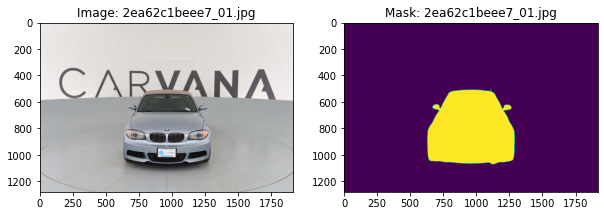

In [9]:
show_random(ALL_IMAGES, ALL_MASKS)

The dataset below reads images and masks and optionally applies augmentation to them.

In [10]:
from typing import List

from torch.utils.data import Dataset


class SegmentationDataset(Dataset):
    def __init__(
        self,
        images: List[Path],
        masks: List[Path] = None,
        transforms=None
    ) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = utils.imread(image_path)
        
        result = {"image": image}
        
        if self.masks is not None:
            mask = gif_imread(self.masks[idx])
            result["mask"] = mask
        
        if self.transforms is not None:
            result = self.transforms(**result)
        
        result["filename"] = image_path.name

        return result

-------

### Augmentations

[![Albumentation logo](https://albumentations.readthedocs.io/en/latest/_static/logo.png)](https://github.com/albu/albumentations)

The [albumentation](https://github.com/albu/albumentations) library works with images and masks at the same time, which is what we need.

In [11]:
from itertools import chain

import albumentations as albu
from albumentations.pytorch import ToTensor


def hard_transforms():
    result = [
        albu.Cutout(),
        albu.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2, p=0.3
        ),
        albu.GridDistortion(p=0.3),
        albu.HueSaturationValue(p=0.3),
    ]
    return result
  

def resize_transforms(pre_size=448, image_size=224, rescale_size=7680, train=True, rescale=False):
    result = [
        albu.LongestMaxSize(max_size=rescale_size, p=1 if rescale else 0),
        albu.RandomScale(scale_limit=(0.8, 1.25), p=1 if train else 0),
        albu.RandomCrop(pre_size, pre_size, p=1 if train else 0),
        albu.CenterCrop(pre_size, pre_size, p=0 if train else 1),
        albu.Resize(image_size, image_size, p=1),
    ]
    return result
  
    
def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]


def compose(*transforms_to_compose, p=1):
    # combine all augmentations into one single pipeline
    transforms_to_compose = chain.from_iterable(transforms_to_compose)
    result = albu.Compose([*transforms_to_compose], p=p)
    return result

In [12]:
show_transforms = compose(
    hard_transforms(),
    resize_transforms(train=False),
)

/data/pjdanilov/.conda/envs/catalyst_dev/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1467: DeprecationWarning:

This class has been deprecated. Please use CoarseDropout



Let's look at the augmented results. <br/>
You can restart the cell below to see more examples of augmentations.

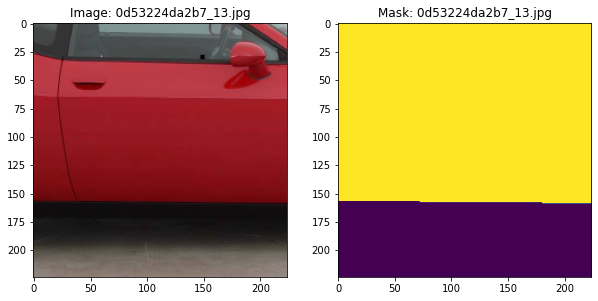

In [13]:
show_random(ALL_IMAGES, ALL_MASKS, transforms=show_transforms)

-------

## Loaders

In [14]:
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

from catalyst.contrib.data.cv.datasets import TiledImageDataset

def get_loaders(
    images: List[Path],
    masks: List[Path],
    random_state: int,
    valid_size: float = 0.2,
    batch_size: int = 32,
    num_workers: int = 4,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    indices = np.arange(len(images))

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(
        indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    # Creates our train dataset
    train_dataset = SegmentationDataset(
        images=np_images[train_indices].tolist(),
        masks=np_masks[train_indices].tolist(),
        transforms=train_transforms_fn
    )

    # Creates our valid dataset
    valid_dataset = SegmentationDataset(
        images=np_images[valid_indices].tolist(),
        masks=np_masks[valid_indices].tolist(),
        transforms=valid_transforms_fn
    )

    # Catalyst uses normal torch.data.DataLoader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        drop_last=True,
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=True,
    )
    
    loaders = collections.OrderedDict(train=train_loader, valid=valid_loader)
    
    return loaders

-------

## Experiment
### Model

Catalyst has [several segmentation models](https://github.com/catalyst-team/catalyst/blob/master/catalyst/contrib/models/segmentation/__init__.py#L16) (Unet, Linknet, FPN, PSPnet and their versions with pretrain from Resnet).

> You can read more about them in [our blog post](https://github.com/catalyst-team/catalyst-info#catalyst-info-1-segmentation-models).

But for now let's take the model from [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch) (SMP for short). The same segmentation architectures have been implemented in this repository, but there are many more pre-trained encoders.

[![Segmentation Models logo](https://raw.githubusercontent.com/qubvel/segmentation_models.pytorch/master/pics/logo-small-w300.png)](https://github.com/qubvel/segmentation_models.pytorch)

In [15]:
import segmentation_models_pytorch as smp

# We will use Feature Pyramid Network with pre-trained ResNeXt50 backbone
model = smp.FPN(encoder_name="resnext50_32x4d", classes=1)

### Model training

We will optimize loss as the sum of IoU, Dice and BCE, specifically this function: $IoU + Dice + 0.8*BCE$.


In [16]:
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss

# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}

In [17]:
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead

learning_rate = 0.001
encoder_learning_rate = 0.0005

# Since we use a pre-trained encoder, we will reduce the learning rate on it.
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=2)

In [18]:
from catalyst.dl import SupervisedRunner

num_epochs = 3
logdir = "./logs/segmentation"

device = utils.get_device()
print(f"device: {device}")

# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

device: cuda


### Running train-loop

In [19]:
from catalyst.dl.callbacks import DiceCallback, IouCallback, CriterionCallback, MetricAggregationCallback

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
]

In [35]:
train_transforms = compose(
    resize_transforms(pre_size=448, image_size=224), 
    hard_transforms(),
    post_transforms(),
)
valid_transforms = compose(
    resize_transforms(pre_size=448, image_size=224),
    post_transforms(),
)

batch_size: int = 32

loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state=SEED,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size
)

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # prints train logs
    verbose=True,
)

1/3 * Epoch (train): 100% 127/127 [01:25<00:00,  1.48it/s, dice=0.965, iou=0.933, loss=0.159, loss_bce=0.071, loss_dice=0.035, loss_iou=0.067]
1/3 * Epoch (valid): 100% 31/31 [00:19<00:00,  1.57it/s, dice=0.965, iou=0.932, loss=0.172, loss_bce=0.085, loss_dice=0.035, loss_iou=0.068]
[2020-07-29 15:08:21,548] 
1/3 * Epoch 1 (_base): lr=0.0005 | momentum=0.9000
1/3 * Epoch 1 (train): dice=0.8357 | iou=0.7453 | loss=0.6233 | loss_bce=0.2554 | loss_dice=0.1643 | loss_iou=0.2547
1/3 * Epoch 1 (valid): dice=0.9624 | iou=0.9277 | loss=0.1540 | loss_bce=0.0551 | loss_dice=0.0376 | loss_iou=0.0723
2/3 * Epoch (train): 100% 127/127 [01:23<00:00,  1.52it/s, dice=0.933, iou=0.874, loss=0.264, loss_bce=0.087, loss_dice=0.067, loss_iou=0.126]
2/3 * Epoch (valid): 100% 31/31 [00:19<00:00,  1.55it/s, dice=0.970, iou=0.942, loss=0.108, loss_bce=0.026, loss_dice=0.030, loss_iou=0.058]
[2020-07-29 15:10:25,993] 
2/3 * Epoch 2 (_base): lr=0.0005 | momentum=0.9000
2/3 * Epoch 2 (train): dice=0.9539 | iou=0

## Tiled Inference

In [20]:
from catalyst.contrib.dl.callbacks.inference import TiledInferenceCallback

In [42]:
TEST_IMAGES = sorted(test_image_path.glob("*.jpg"))

infer_transforms = compose(post_transforms())

infer_dataset = TiledImageDataset(
    images=TEST_IMAGES[:5],
    train=False,
    tile_size=448,
    tile_step=224,
    input_key="image",
    transform=infer_transforms,
)

batch_size: int = 32
num_workers: int = 4

infer_loader = DataLoader(
    infer_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

runner.infer(
    model=model,
    loaders=collections.OrderedDict(infer=infer_loader),
    callbacks=[TiledInferenceCallback(save_dir="predictions")],
    resume=f"{logdir}/checkpoints/best.pth",
    verbose=True,
)

=> Loading checkpoint ./logs/segmentation/checkpoints/best.pth
loaded state checkpoint ./logs/segmentation/checkpoints/best.pth (global epoch 3, epoch 3, stage train)
1/1 * Epoch (infer): 100% 7/7 [00:04<00:00,  1.73it/s]


First, let's visualize original images and their predicted masks.

In [21]:
from skimage.io import imread

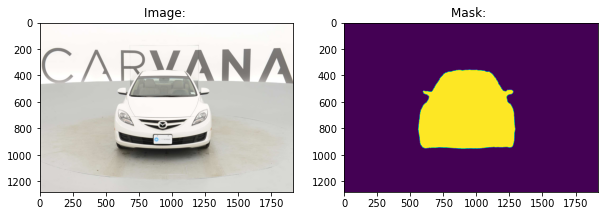

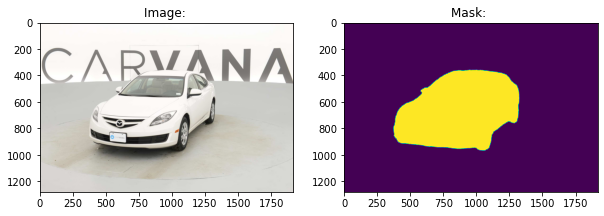

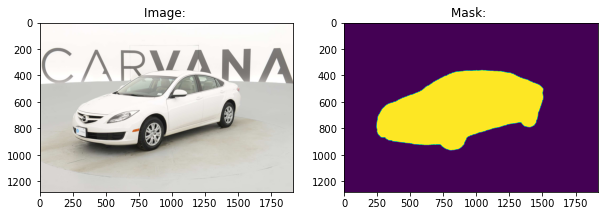

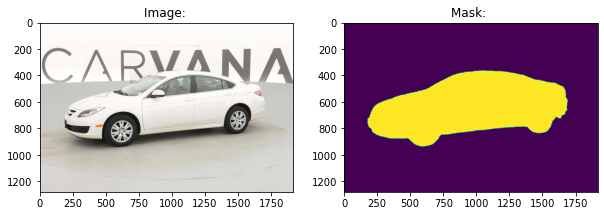

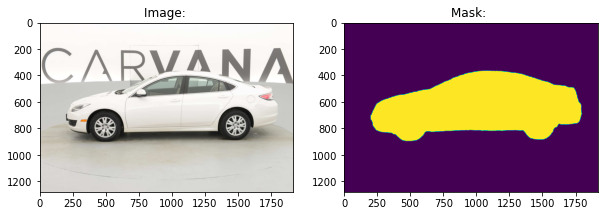

In [43]:
masks = np.load("predictions/masks.npy")
n_predictions = masks.shape[0]

for i, image_path in enumerate(TEST_IMAGES[:n_predictions]):
    image = imread(image_path)
    mask = masks[i]
    show_examples(name="", image=image, mask=mask)

Also you can obtain predicted probabilities and visualize them along with originals.

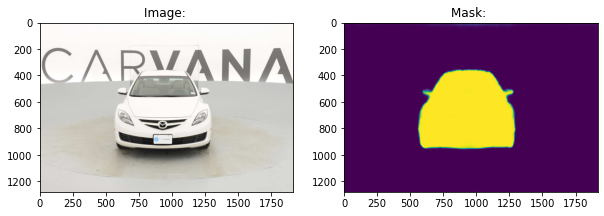

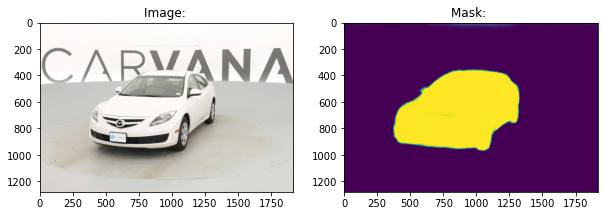

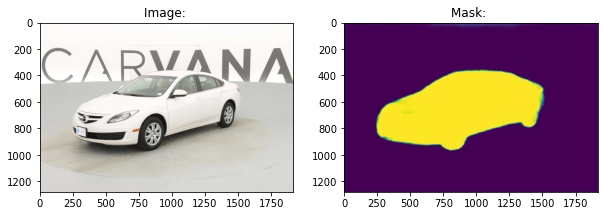

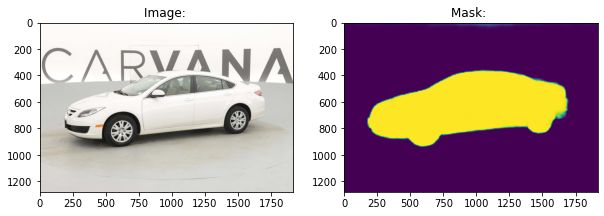

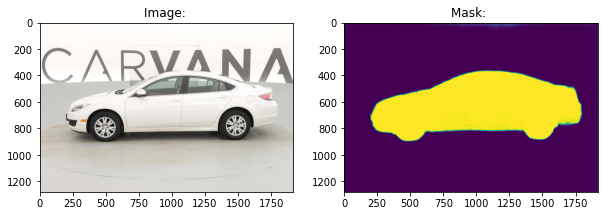

In [44]:
probs = np.load("predictions/probs.npy")

for i, image_path in enumerate(TEST_IMAGES[:n_predictions]):
    image = imread(image_path)
    prob = probs[i][0]
    show_examples(name="", image=image, mask=prob)

In [27]:
model = smp.FPN(encoder_name="resnext50_32x4d", classes=1)
model_params = utils.process_model_params(model, layerwise_params=layerwise_params)
base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=2)

In [22]:
train_transforms = compose(
    resize_transforms(pre_size=896, image_size=448, rescale=True), 
    hard_transforms(), 
    post_transforms(),
)
valid_transforms = compose(
    resize_transforms(pre_size=896, image_size=448, rescale=True),
    post_transforms(),
)

batch_size: int = 4
num_epochs: int = 3

loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state=SEED,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size
)

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # prints train logs
    verbose=True,
)

/data/pjdanilov/.conda/envs/catalyst_dev/lib/python3.8/site-packages/albumentations/pytorch/transforms.py:58: DeprecationWarning:

ToTensor is deprecated and will be replaced by ToTensorV2 in albumentations 0.5.0



1/3 * Epoch (train):   0% 1/1017 [00:05<1:32:36,  5.47s/it, dice=0.117, iou=0.062, loss=2.862, loss_bce=1.300, loss_dice=0.883, loss_iou=0.938]

/opt/conda/conda-bld/pytorch_1591914858187/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning:

This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha)



1/3 * Epoch (train): 100% 1017/1017 [08:17<00:00,  2.04it/s, dice=0.000e+00, iou=0.000e+00, loss=2.129, loss_bce=0.161, loss_dice=1.000, loss_iou=1.000]
1/3 * Epoch (valid): 100% 254/254 [02:02<00:00,  2.08it/s, dice=0.896, iou=0.812, loss=0.681, loss_bce=0.487, loss_dice=0.104, loss_iou=0.188]            
[2020-07-31 17:07:17,792] 
1/3 * Epoch 1 (_base): lr=0.0005 | momentum=0.9000
1/3 * Epoch 1 (train): dice=0.5736 | iou=0.4878 | loss=1.2853 | loss_bce=0.4335 | loss_dice=0.4264 | loss_iou=0.5122
1/3 * Epoch 1 (valid): dice=0.6126 | iou=0.5568 | loss=0.9877 | loss_bce=0.1965 | loss_dice=0.3874 | loss_iou=0.4432
2/3 * Epoch (train): 100% 1017/1017 [08:12<00:00,  2.06it/s, dice=0.996, iou=0.991, loss=0.017, loss_bce=0.005, loss_dice=0.004, loss_iou=0.009]        
2/3 * Epoch (valid): 100% 254/254 [01:57<00:00,  2.15it/s, dice=0.978, iou=0.958, loss=0.072, loss_bce=0.011, loss_dice=0.022, loss_iou=0.042]            
[2020-07-31 17:17:55,838] 
2/3 * Epoch 2 (_base): lr=0.0005 | momentum=0

In [23]:
infer_transforms = compose(post_transforms())

infer_dataset = TiledImageDataset(
    images=[Path("car_8k.jpg")],
    train=False,
    tile_size=448,
    tile_step=224,
    input_key="image",
    transform=infer_transforms,
)

num_workers: int = 4
batch_size: int = 32

infer_loader = DataLoader(
    infer_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

runner.infer(
    model=model,
    loaders=collections.OrderedDict(infer=infer_loader),
    callbacks=[TiledInferenceCallback(save_dir="predictions")],
    resume=f"{logdir}/checkpoints/best.pth",
    verbose=True,
)

=> Loading checkpoint ./logs/segmentation/checkpoints/best.pth
loaded state checkpoint ./logs/segmentation/checkpoints/best.pth (global epoch 5, epoch 5, stage train)
1/1 * Epoch (infer): 100% 24/24 [02:05<00:00,  5.25s/it]


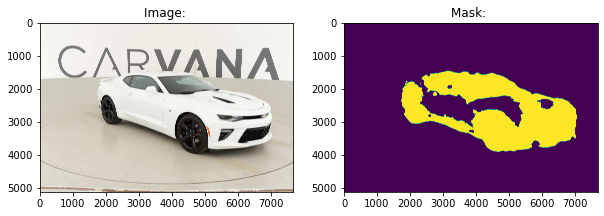

In [24]:
from skimage.io import imread

masks = np.load("predictions/masks.npy")

for i, image_path in enumerate([Path("car_8k.jpg")]):
    image = imread(image_path)
    mask = masks[i]
    show_examples(name="", image=image, mask=mask)

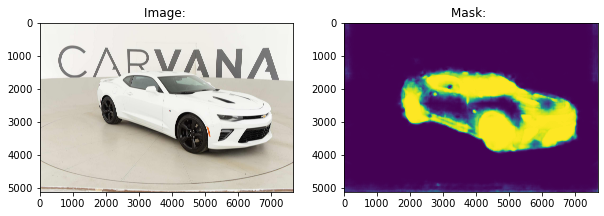

In [25]:
probs = np.load("predictions/probs.npy")

for i, image_path in enumerate([Path("car_8k.jpg")]):
    image = imread(image_path)
    prob = probs[i][0]
    show_examples(name="", image=image, mask=prob)